[Creating flowcharts with {ggplot2}](https://nrennie.rbind.io/blog/2022-06-06-creating-flowcharts-with-ggplot2/)

In [ ]:
library(tidyverse)
library(igraph)
library(showtext)
library(rcartocolor)

In [2]:
goldilocks <- tibble(
    from = c(
        "Goldilocks",
        "Porridge", "Porridge", "Porridge",
        "Just right",
        "Chairs", "Chairs", "Chairs",
        "Just right2",
        "Beds", "Beds", "Beds",
        "Just right3"
    ),
    to = c(
        "Porridge",
        "Too cold", "Too hot", "Just right",
        "Chairs",
        "Still too big", "Too big", "Just right2",
        "Beds",
        "Too soft", "Too hard", "Just right3",
        "Bears!"
    )
)

In [3]:
goldilocks

from,to
<chr>,<chr>
Goldilocks,Porridge
Porridge,Too cold
Porridge,Too hot
Porridge,Just right
Just right,Chairs
Chairs,Still too big
Chairs,Too big
Chairs,Just right2
Just right2,Beds


In [4]:
g <- graph_from_data_frame(goldilocks, directed = TRUE)
coords <- layout_as_tree(g)
colnames(coords) <- c("x", "y")

In [5]:
coords

x,y
0,7
0,6
-1,5
-1,4
-2,3
-2,2
-3,1
0,5
1,5
-1,3


In [6]:
output_df <- as_tibble(coords) %>%
    mutate(
        step = vertex_attr(g, "name"),
        label = gsub("\\d+$", "", step),
        x = x * -1,
        type = factor(c(1, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 1))
    )
output_df

x,y,step,label,type
<dbl>,<dbl>,<chr>,<chr>,<fct>
0,7,Goldilocks,Goldilocks,1
0,6,Porridge,Porridge,2
1,5,Just right,Just right,3
1,4,Chairs,Chairs,2
2,3,Just right2,Just right,3
2,2,Beds,Beds,2
3,1,Just right3,Just right,3
0,5,Too cold,Too cold,3
-1,5,Too hot,Too hot,3


In [7]:
plot_nodes <- output_df %>%
    mutate(
        xmin = x - 0.35,
        xmax = x + 0.35,
        ymin = y - 0.25,
        ymax = y + 0.25
    )
plot_nodes

x,y,step,label,type,xmin,xmax,ymin,ymax
<dbl>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,7,Goldilocks,Goldilocks,1,-0.35,0.35,6.75,7.25
0,6,Porridge,Porridge,2,-0.35,0.35,5.75,6.25
1,5,Just right,Just right,3,0.65,1.35,4.75,5.25
1,4,Chairs,Chairs,2,0.65,1.35,3.75,4.25
2,3,Just right2,Just right,3,1.65,2.35,2.75,3.25
2,2,Beds,Beds,2,1.65,2.35,1.75,2.25
3,1,Just right3,Just right,3,2.65,3.35,0.75,1.25
0,5,Too cold,Too cold,3,-0.35,0.35,4.75,5.25
-1,5,Too hot,Too hot,3,-1.35,-0.65,4.75,5.25


In [8]:
plot_edges <- goldilocks %>%
    mutate(id = row_number()) %>%
    pivot_longer(
        cols = c("from", "to"),
        names_to = "s_e", values_to = "step"
    ) %>%
    left_join(plot_nodes, by = "step") %>%
        select(-c(label, type, y, xmin, xmax)) %>%
        mutate(y = ifelse(s_e == "from", ymin, ymax)) %>%
        select(-c(ymin, ymax))
plot_edges

id,s_e,step,x,y
<int>,<chr>,<chr>,<dbl>,<dbl>
1,from,Goldilocks,0,6.75
1,to,Porridge,0,6.25
2,from,Porridge,0,5.75
2,to,Too cold,0,5.25
3,from,Porridge,0,5.75
3,to,Too hot,-1,5.25
4,from,Porridge,0,5.75
4,to,Just right,1,5.25
5,from,Just right,1,4.75


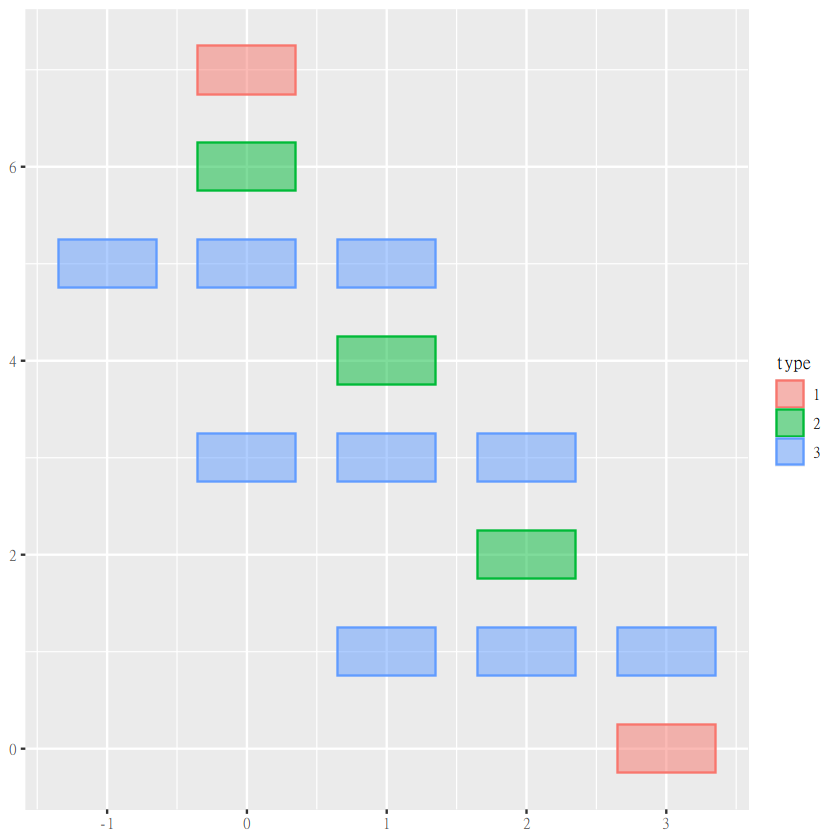

In [9]:
p <- ggplot() +
    geom_rect(
        data = plot_nodes,
        mapping = aes(
            xmin = xmin,
            ymin = ymin,
            xmax = xmax,
            ymax = ymax,
            fill = type,
            colour = type
        ),
        alpha = 0.5
    )
p

In [10]:
font_add_google(name = "Henny Penny", family = "henny")
showtext_auto()

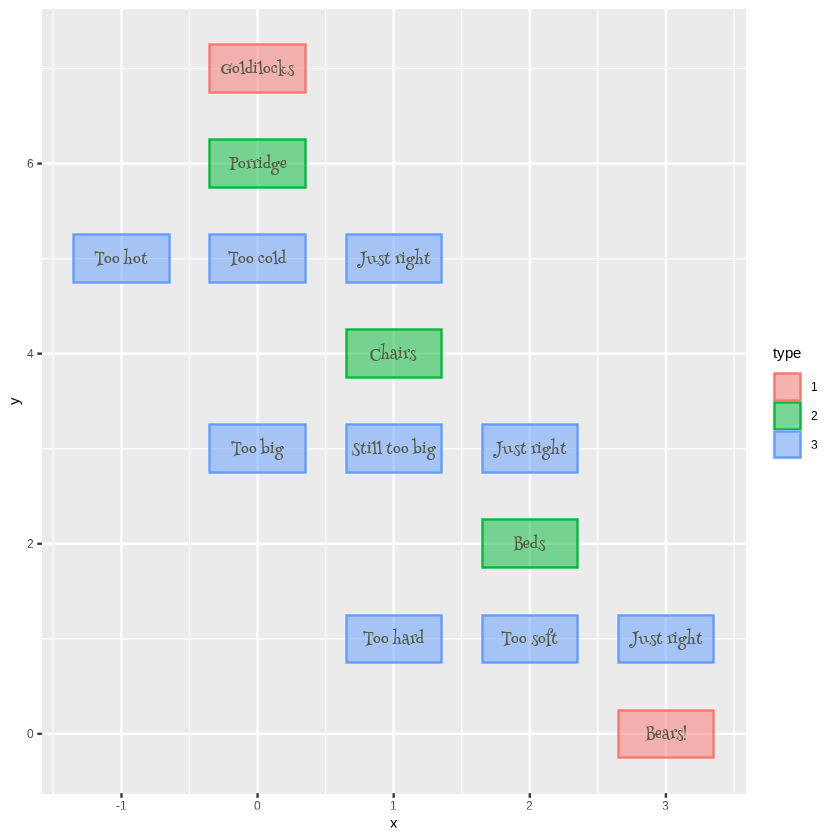

In [11]:
p <- p +
    geom_text(
        data = plot_nodes,
        mapping = aes(
            x = x,
            y = y,
            label = label
        ),
        family = "henny",
        color = "#585c45"
    )
p

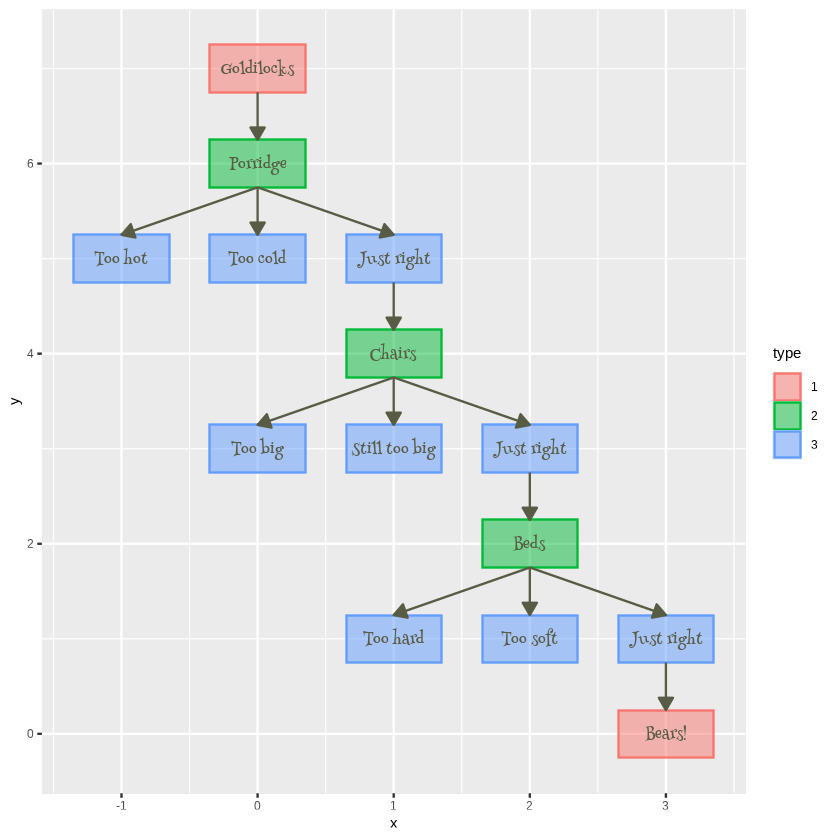

In [12]:
p <- p +
    geom_path(
        data = plot_edges,
        mapping = aes(
            x = x,
            y = y,
            group = id
        ),
        color = "#585c45",
        arrow = arrow(
            length = unit(0.3, "cm"),
            type = "closed"
        )
    )
    p

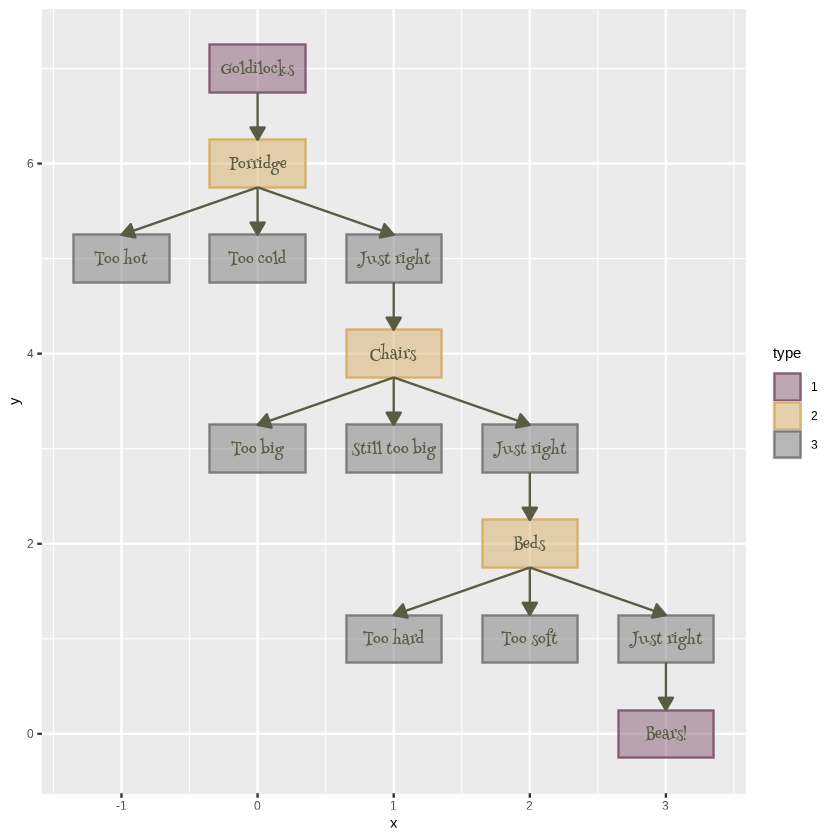

In [13]:
p = p +
    scale_fill_carto_d(palette = "Antique") +
    scale_color_carto_d(palette = "Antique")
p

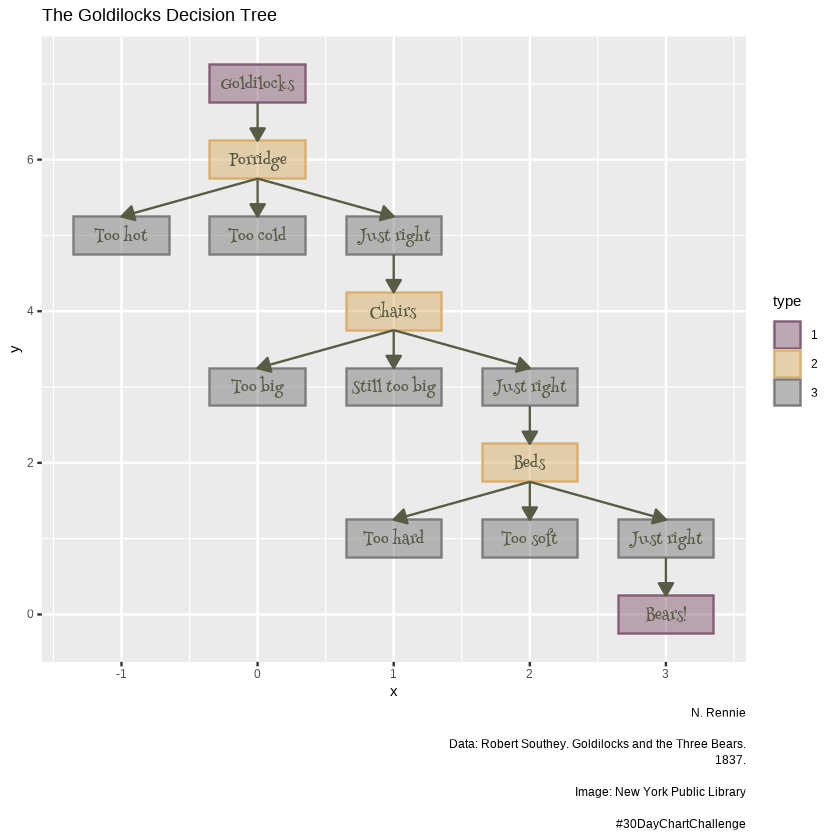

In [14]:
p <- p +
    labs(
        title = "The Goldilocks Decision Tree",
        caption = "N. Rennie\n\nData: Robert Southey. Goldilocks and the Three Bears.
       1837.\n\nImage: New York Public Library\n\n#30DayChartChallenge"
    )
p

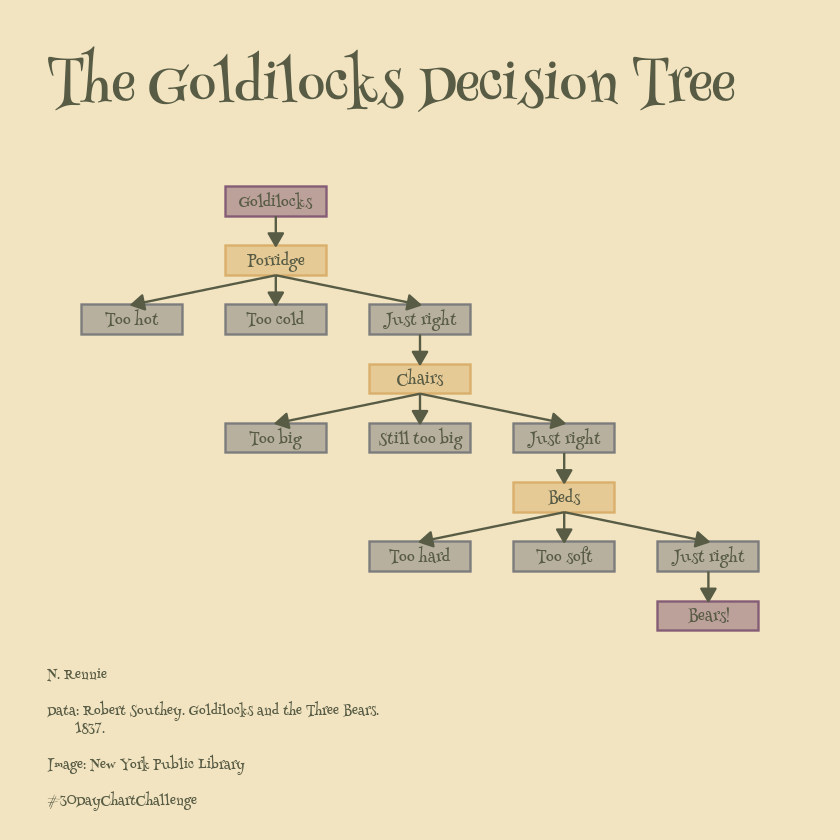

In [16]:
p <- p +
    theme_void() +
    theme(
        plot.margin = unit(c(1, 1, 0.5, 1), "cm"),
        legend.position = "none",
        plot.background = element_rect(colour = "#f2e4c1", fill = "#f2e4c1"),
        panel.background = element_rect(colour = "#f2e4c1", fill = "#f2e4c1"),
        plot.title = element_text(
            family = "henny", hjust = 0, face = "bold",
            size = 40, color = "#585c45",
            margin = margin(t = 10, r = 0, b = 10, l = 0)
        ),
        plot.caption = element_text(
            family = "henny", hjust = 0,
            size = 10, color = "#585c45",
            margin = margin(t = 10)
        )
    )
p